In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.colors as colors
import matplotlib.animation as animation
from scipy import stats
from scipy.special import erfc
from scipy.signal import gaussian
from scipy.ndimage import convolve1d
import peakutils
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import random
from random import shuffle
import pickle
import copy
from src.codonTable import codonTable
from src.codonUtils import utils
from src.thunderflask import thunderflask
from src.bacteria import strain

sns.set_context("paper")
# get fast fail table
ff_path = '/home/jon/Dropbox/Lab/Fast Fail/res/Isaac-pickle-jar/FFpickles/'
with open(ff_path+'ff20_table.pickle', 'rb') as handle:
    fftable = codonTable(table=pickle.load(handle))
# get ff16 table
with open(ff_path+'ff16_table.pickle', 'rb') as handle:
    ff16_table = codonTable(table=pickle.load(handle))
# get reductionist code 
with open('/home/jon/Lab/Fast Fail/res/Reductionist Code/reductionist20.pickle', 'rb') as handle:
    red20 = codonTable(pickle.load(handle))

# get reduct14 code
with open('/home/jon/Lab/Fast Fail/res/Reductionist Code/reductionist15.pickle', 'rb') as handle:
    red15 = codonTable(pickle.load(handle))
    
# get promiscuous tables
promisc20 = codonTable(utils.promiscuity(red20.codonDict))
promisc15 = codonTable(utils.promiscuity(red15.codonDict))

# get random table
with open('res/random_table_manuscript.pickle', 'rb') as handle:
    rand = codonTable(table=pickle.load(handle))
    
# get standard code
sc = codonTable()  
# get colorado code
col = codonTable(table=utils.coloradoTable)

# define colors
color_palette = sns.color_palette("Paired", 12, desat=0.75).as_hex()

colordict = {
    'Standard Code' : color_palette[1],
    'Colorado' : color_palette[5],
    'FF20' : color_palette[3],
    'FF16' : color_palette[2],
    'RED20' : color_palette[7],
    'RED15' : color_palette[6],
    'PROMISC20' : color_palette[9],
    'PROMISC15' : color_palette[8],
    'FFQUAD' : color_palette[9]
}

# color normalization class. from matplotlib example code "https://matplotlib.org/users/colormapnorms.html"
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

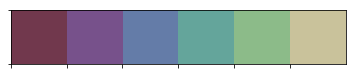

In [130]:
sns.palplot(sns.cubehelix_palette(6, start=2.25, rot=-1.7, dark=0.3, light=0.75, reverse=True))

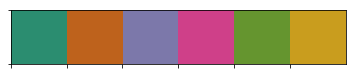

In [161]:
sns.palplot(sns.color_palette("Dark2", 6, desat=0.75))

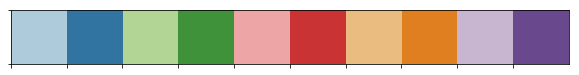

In [159]:
sns.palplot(sns.color_palette("Paired", 10, desat=0.75))

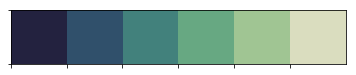

In [95]:
sns.palplot(sns.cubehelix_palette(6, start=0.3, rot=-0.7, reverse=True))

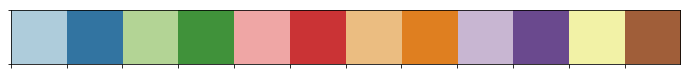

In [8]:
sns.palplot(color_palette)

### Generate Random Tables

In [5]:
# define number of trials to run
N = 1000000
# preallocate memory for statistics
silencicities = np.zeros(N)
mutabilities = np.zeros(N)
# perform N trials
for i in tqdm(range(N)):
    # generage graph
    ct = utils.randomTable(wobble_rule='unrestricted')
    silencicities[i] = utils.silencicity(ct)
    mutabilities[i] = utils.mutability(ct)


100%|██████████| 1000000/1000000 [13:09<00:00, 1265.92it/s]


NameError: name 'rand_silencicities' is not defined

In [2]:
# perform fitting for two distributions
def fitter(array):
    # fit data
    s, loc, scale = stats.lognorm.fit(array)
    x = np.linspace(0, 2*max(array), 1000)
    pdf_fit = stats.lognorm.pdf(x, s, loc=loc, scale=scale)
    params = [s, loc, scale]
    plt.plot(x, pdf_fit, '--b', alpha=0.5, label='Fit')
    return x, pdf_fit, params
x_silence, pdf_silence, param_silence = fitter(silencicities/100)
x_mutate, pdf_mutate, param_mutate = fitter(mutabilities)

NameError: name 'silencicities' is not defined

In [12]:
# pickle data for data permanence
to_dump = [silencicities/100, x_silence, pdf_silence, param_silence,
           mutabilities, x_mutate, pdf_mutate, param_mutate]
with open('res/fig1d.pickle', 'wb') as handle:
    pickle.dump(to_dump, handle)

## Figure 1: Genetic Codes Can Be Optimized for Desired Evolutionary Dynamics 

In [3]:
################
# Figures 1a-c #
################

# plot and save some shiznit
path = '/home/jon/Lab/Fast Fail/Figures/Figure 1/'
#rand.plotGraph(filename=path+'rand_graph.svg')
# sc.plotGraph()#filename=path+'sc_graph.svg')
#col.plotGraph(filename=path+'col_graph.svg')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


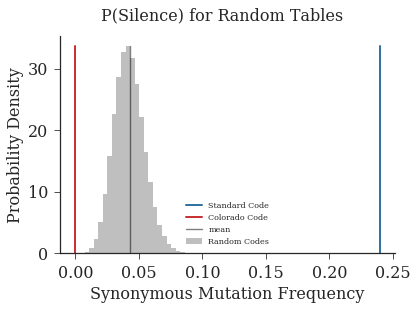

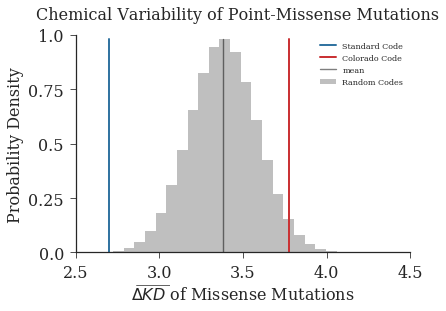

In [6]:
################
# Figures 1d-e #
################

# get data from pickle
with open('res/fig1d.pickle', 'rb') as handle:
    [silencicities, x_silence, pdf_silence, param_silence,
    mutabilities, x_mutate, pdf_mutate, param_mutate] = pickle.load(handle)
    
# Silencicity

# control aesthetics
sns.set_style('white')
sns.set_style('ticks')

labelsize=16
width = 4
height = width / 1.618

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

# faster version of Silence plot: for when the values have already been calculated
#weights = np.ones(len(silencicities))/len(silencicities)
n, bins, patches = plt.hist(silencicities, 30, normed=1, #weights=weights,
                            color='grey', alpha=0.5, label='Random Codes')
plt.suptitle('P(Silence) for Random Tables', fontsize=labelsize)
plt.xlabel('Synonymous Mutation Frequency')
plt.ylabel('Probability Density')
# fit data
def plotfit(x, pdf_fit):
    plt.plot(x, pdf_fit, 'k', alpha=0.5, label='Fit')
    return pdf_fit
# plotfit(x_silence, pdf_silence)
# plt.xscale('log')

# define function for plotting individual lines given codonDict
def silentLiner(table, n, color, alpha, label):
    # calculate silencicities
    Silencicity = utils.silencicity(table.codonDict)
    Xs = np.ones(100)*Silencicity
    Ys = np.linspace(0, max(n), len(Xs))
    plt.plot(Xs, Ys, color=color, alpha=alpha, label=label, linewidth=2)
    
# plot line showing Standard Code
silentLiner(sc, n, colordict['Standard Code'], 1, 'Standard Code')
# plot line showing colorado code
silentLiner(col, n, colordict['Colorado'], 1, 'Colorado Code')
#plot line showing random table
value = silencicities.mean()
Xs = np.ones(100)*value
Ys = np.linspace(0, max(n), len(Xs))
plt.plot(Xs, Ys, '-', color='black', alpha=0.5, label='mean')
# plt.xlim([0, 25])
# plt.ylim([0, 0.55])
fig = plt.gcf()
ax = plt.gca()
#h, l = ax.get_legend_handles_labels()
#h = [h[-1], h[0], h[1]]
#l = [l[-1], l[0], l[1]]
ax.legend()#h, l)
sns.despine()#trim=True)
# plt.savefig('/home/jonathan/Dropbox/Lab/Fast Fail/Figures/Figure 1/silencicity.svg', bbox_inches='tight')
plt.show()

# Mutability

# faster version of Silence plot: for when the values have already been calculated
#weights = np.ones(len(silencicities))/len(silencicities)
n, bins, patches = plt.hist(mutabilities, 30, normed=1, #weights=weights,
                            color='grey', alpha=0.5, label='Random Codes')
plt.suptitle('Chemical Variability of Point-Missense Mutations', fontsize=labelsize)
plt.xlabel(r'$\widebar{\Delta KD}$ of Missense Mutations')
plt.ylabel('Probability Density')
# fit data
# plotfit(x_mutate, pdf_mutate)
#plt.xscale('log')
# define function for plotting individual lines given codonDict
def silentLiner2(table, n, color, alpha, label):
    # calculate silencicities
    mutability = utils.mutability(table.codonDict)
    Xs = np.ones(100)*mutability
    Ys = np.linspace(0, max(n), len(Xs))
    plt.plot(Xs, Ys, '-', color=color, alpha=alpha, label=label, linewidth=2)
# plot line showing Standard Code
silentLiner2(sc, n, colordict['Standard Code'], 1, 'Standard Code')
# plot line showing colorado code
silentLiner2(col, n, colordict['Colorado'], 1, 'Colorado Code')
#plot line showing random table
value = mutabilities.mean()
Xs = np.ones(100)*value
Ys = np.linspace(0, max(n), len(Xs))
plt.plot(Xs, Ys, '-', color='black', alpha=0.5, label='mean')
# format ticks
loc, __ = plt.yticks()
ylabels = ['{0}'.format(num/4) for num in range(9)]
plt.yticks(loc, ylabels)
fig = plt.gcf()
ax = plt.gca()
#h, l = ax.get_legend_handles_labels()
#h = [h[-1], h[0], h[1]]
#l = [l[-1], l[0], l[1]]
ax.legend()#h, l
plt.ylim(0,2)
plt.xlim(2.5,4.5)
sns.despine()
# plt.savefig('/home/jonathan/Dropbox/Lab/Fast Fail/Figures/Figure 1/mutability.svg', bbox_inches='tight')
plt.show()

In [12]:
mutabilities.mean() / utils.mutability(table=sc.codonDict)

1.2538647770981934

In [28]:
# calculate p value and 1 in foo of standard table silencicity
[s, loc, scale] = param_silence
z = (utils.silencicity(sc.codonDict) - loc) / scale
sig = np.log(z)/s
p = erfc(sig/np.sqrt(2))

oneInFoo = 1 / p
print('1 in {:.2e}'.format(oneInFoo))

1 in 1.01e+24


In [27]:
ticks = ['{0}'.format(num/4) for num in range(8)]
ticks

['0.0', '0.25', '0.5', '0.75', '1.0', '1.25', '1.5', '1.75']

In [50]:
sc_copy = copy.deepcopy(utils.standardTable)
aa_s = utils.residues
block_array = []
# loop over amino acids
for aa in aa_s:
    # get the block associated with that amino acid
    block = dict((key,value) for key, value in sc_copy.items() if value == aa)
    # store in block array
    block_array.append(block)

# loop over blocks
choices = []
for i, block in enumerate(block_array):
    # get choice
    choice = random.choice(list(block))
    # loop over codons in block
    for codon in list(block):
        # set all non-choice codons in block to stop
        if codon != choice: block[codon] = '*'
    # append choice to choices
    choices.append(choice)
print(block_array[3])

{'CUG': '*', 'UUG': '*', 'CUC': '*', 'UUA': 'L', 'CUU': '*', 'CUA': '*'}


## Figure 2: Fast Fail Genetic Codes Can Hinder Evolution

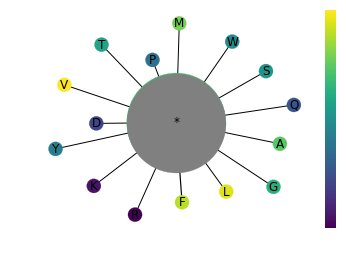

In [4]:
################
# Figures 2a-c #
################

# plot and save some shiznit
path = '/home/jon/Lab/Fast Fail/Figures/Figure 2/'
# fftable.codonTable.to_csv(path+'fftable.csv')
# fftable.plotGraph()#filename=path+'ff_graph.svg')
# ff16_table.codonTable.to_csv(path+'ff16.csv')
# ff16_table.plotGraph(filename=path+'ff16_graph.svg')
# red20.plotGraph(filename=path+'reductionist_graph.svg')
# red20.codonTable.to_csv(path+'red20.csv')
red15.plotGraph(filename=path+'reduct15_graph.svg')
red15.codonTable.to_csv(path+'red15.csv')

## Figure 3: Evolution is easier to arrest than accelerate 

Iteration Number: : 100%|██████████| 10000/10000 [03:06<00:00, 58.59it/s]


HBox(children=(IntProgress(value=0, description='Looping through all strains: ', max=20397), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Plotting Lineages: ', max=20397), HTML(value='')))

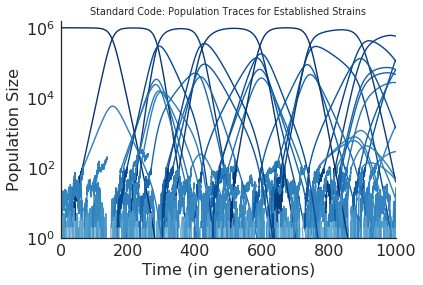

In [7]:
#############
# Figure 3a #
#############

# control aesthetics
sns.set_style('white')
sns.set_style('ticks')

labelsize=16
width = 4
height = width / 1.618

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

# populate sim
LUCA = strain(N_pop=1e6, fitness=0, mu=2e-5)
sim = thunderflask(LUCA)
# initialize some variables
T_curr = 0
mut_param = [1, 2]
dt = 0.1
T_sim = 1000

# run simulation
sim.simulate(T_sim, dt, T_curr, mut_param, save_all=True, prune_strains=True,
             show_progress=True)

# plot results
strainlist = []
for bact in tqdm(sim.allStrains, desc='Looping through all strains'):
    try:
        strainlist.append((max(bact.poptrace), bact))
    except:
        strainlist.append((0, bact))
sortedlist = sorted(strainlist, key=lambda x: x[0])
endlist = [(i, bact) for i, (__, bact) in enumerate(reversed(sortedlist))]
shuffle(endlist)

n_big = 30
n_smol = len(sortedlist) - n_big
bigcolors = pl.cm.Blues(np.linspace(1,0.7, n_big))
smallcolors = pl.cm.Blues(np.linspace(0.7, 0, n_smol))
ind = 0
for i, bact in tqdm((endlist), desc='Plotting Lineages'):
    if (i < 30) :
        t = bact.timepoints
        pop = bact.poptrace
        plt.semilogy(t, pop, color=bigcolors[i])
    elif (i % 20 == 0):
        t = bact.timepoints
        pop = bact.poptrace
        plt.semilogy(t, pop, color=smallcolors[i-n_big])
            
plt.xlabel('Time (in generations)')
plt.ylabel('Population Size')
# plt.title('Standard Code: Population Traces for Established Strains')
plt.xlim([T_curr, T_sim])
plt.ylim([1e0, 10**(6.2)])
sns.despine()
plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 3/3a_strain_traces_2.svg')
plt.show()

In [16]:
#############
# Figure 3b #
#############
DF = pd.DataFrame()
filenames = [
    '/home/jon/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Standard_Code_1/output/2018-03-23_Standard_Code_1_concatenated.pickle', # standard code
#     '/home/jon/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Colorado_0/output/2018-03-23_Colorado_0_concatenated.pickle', # colorado
#     '/home/jon/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FF20_0/output/2018-03-23_FF20_0_concatenated.pickle', # FF20
#     '/home/jon/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FF16_0/output/2018-03-23_FF16_0_concatenated.pickle', # FF16
    '/home/jon/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/RED20_0/output/2018-04-10_RED20_0_concatenated.pickle', # RED20
    '/home/jon/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/RED15_0/output/2018-04-30_RED15_0_concatenated.pickle', # RED15
#     '/home/jon/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/PROMISC20_0/output/2018-04-30_PROMISC20_0_concatenated.pickle', # PROMISC20
#     '/home/jon/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/PROMISC15_1/output/2018-07-12_PROMISC15_1_concatenated.pickle'
]
# get dataframes
dfs = []
for file in filenames:
    with open(file, 'rb') as handle:
        dfs.append(pickle.load(handle).loc[9999])
DF = pd.concat(dfs, copy=False)
# with open(filenames[0], 'rb') as handle:
#     df = pickle.load(handle)

In [19]:
set(DF['code'])

{'Colorado', 'FF16', 'FF20', 'PROMISC20', 'RED14', 'RED20', 'Standard Code'}

In [17]:
# calculate statistics on endpoint fitness
def fit_analysis(DF, code):
    # extract fitness array
    fitnesses = DF.loc[DF['code'] == code, 'fitness']
    rates = fitnesses/1000
    # perform statistics on said distribution
    fit_stats ={
        'mean':np.mean(fitnesses),
        'median': np.median(fitnesses),
        'var':np.var(fitnesses),
        'range':(min(fitnesses), max(fitnesses)),
        'percentiles':[(q/100, np.percentile(fitnesses, q)) for q in [1, 5, 10, 25, 50, 75, 90, 95, 99]]
    }
    rate_stats = {
        'mean':np.mean(rates),
        'median': np.median(rates),
        'var':np.var(rates),
        'range':(min(rates), max(rates)),
        'percentiles':[(q/100, np.percentile(rates, q)) for q in [1, 5, 10, 25, 50, 75, 90, 95, 99]]
    }
    return fitnesses, fit_stats, rate_stats
sc_endfitness, sc_fitstats, sc_ratestats = fit_analysis(DF, 'Standard Code')
# col_endfitness, col_fitstats, col_ratestats = fit_analysis(DF, 'Colorado')
# FF20_endfitness, FF20_fitstats, FF20_ratestats = fit_analysis(DF, 'FF20')
# FF16_endfitness, FF16_fitstats, FF16_ratestats = fit_analysis(DF, 'FF16')
RED20_endfitness, RED20_fitstats, RED20_ratestats = fit_analysis(DF, 'RED20')
RED15_endfitness, RED15_fitstats, RED15_ratestats = fit_analysis(DF, 'RED15')
# PROMISC20_endfitness, PROMISC20_fitstats, PROMISC20_ratestats = fit_analysis(DF, 'PROMISC20')
# PROMISC15_endfitness, PROMISC15_fitstats, PROMISC15_ratestats = fit_analysis(DF, 'PROMISC15')

In [33]:
np.sqrt(FF20_ratestats['var'])

8.773618850864056e-05

In [15]:
RED20_fitstats['mean']/sc_fitstats['mean']

NameError: name 'RED20_fitstats' is not defined

In [36]:
RED20_ratestats

{'mean': 0.0002544657624689533,
 'median': 0.0002483793167970137,
 'percentiles': [(0.01, 8.762529902758803e-05),
  (0.05, 0.00013074945030970786),
  (0.1, 0.00015670571226371333),
  (0.25, 0.0001942174156261974),
  (0.5, 0.0002483793167970137),
  (0.75, 0.00030792865551379533),
  (0.9, 0.0003622388097691018),
  (0.95, 0.0003993438179335739),
  (0.99, 0.00047969650581066527)],
 'range': (3.222431153051062e-05, 0.0005914776862276309),
 'var': 6.814317948060327e-09}

In [3]:
# extract dataframe for figure 3
codes_3b = ['Colorado', 'Standard Code']
codes_3c = list(set(DF['code']) - set(codes_3b))
f = lambda code: code in codes_3b
g = lambda code: not f(code)
DF_3b = DF.loc[DF['code'].map(f)]
DF_3c = DF.loc[DF['code'].map(g)]


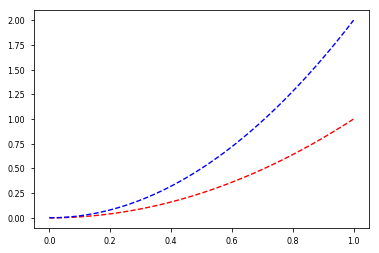

In [10]:
x = np.linspace(0,1)
y = x **2 
plt.plot(x, y, '--r')
plt.savefig('test.png')
plt.plot(x, y*2, '--b')
plt.savefig('test2.png')

In [68]:
# wanted_codes = ['Standard Code', 'Colorado', 'FF20']
# wanted_codes= ['Reductionist20', 'PROMISC20']
f = lambda code: code in wanted_codes 
DF_3b = DF.loc[DF['code'].map(f)]

In [174]:
# optional individual dataframe loading
with open('/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Standard_Code_1/output/2018-03-23_Standard_Code_1_concatenated.pickle', 'rb') as handle:
    df = pickle.load(handle)
    df_sc = df[(df['time'] > 100) & (df['time']) < 300]
    # df_sc.set_index(['code', 'sim'], inplace=True)
    del df
    
with open('/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Colorado_0/output/2018-03-23_Colorado_0_concatenated.pickle', 'rb') as handle:
    df = pickle.load(handle)
    df_col = df[(df['time'] > 100) & (df['time']) < 300]
    # df_col.set_index(['code', 'sim'], inplace=True)
    del df
    
# with open('/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FF20_0/output/2018-03-23_FF20_0_concatenated.pickle', 'rb') as handle:
#     df_ff20_3b = pickle.load(handle)   


/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


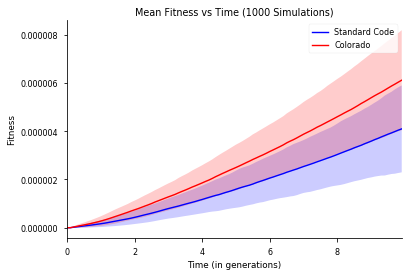

In [4]:
ax1 = sns.tsplot(
    data=DF_3b, 
    time='time', 
    value='fitness', 
    unit='sim', 
    condition='code', 
    color=colordict, 
    ci='sd'
)
#ax2 = sns.tsplot(data=df_col_3b, time='time', value='fitness', unit='sim', condition='code', color='red')
#ax3 = sns.tsplot(data=df_ff20_3b, time='time', value='fitness', unit='sim', condition='code', color='green')

plt.legend()
plt.title('Mean Fitness vs Time (1000 Simulations)')
plt.xlabel('Time (in generations)')
plt.ylabel('Fitness')
sns.despine()
plt
#plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 3/3b_fit_traces.pdf')
plt.show()

In [32]:
code = 'FF20'
DF_3b.loc[DF_3b['code'] == code].loc[7]['time'].iloc[0]
# fitnesses[code] = [df.loc[i, 'fitness'].iloc[nFrame-bumper] for i in sims]

0.7000700070007

In [52]:
################
# Figures 3c-d #
################
sims = set(DF_3b['sim'])
codes = set(DF_3b['code'])
lags = []
rates = []
# loop over codes
for code in tqdm(codes, desc='Looping over Codes'):
    # declare storage variables
    t_lag = np.zeros(len(sims))
    rate = np.zeros(len(sims))
    DF = DF_3b.loc[DF_3b['code'] == code]
    for i, sim in enumerate(tqdm(sims, desc='Looping over Sims')):
        # extract data for this sim
        data = DF.loc[DF['sim'] == sim]
        t = data['time'].values
        f = data['fitness'].values
        # smooth with gaussian filter
        gaussian_filter = gaussian(30, 10)
        filtered_signal = convolve1d(f, gaussian_filter/gaussian_filter.sum())
        # calculate first derivative  
        delt = np.diff(t)
        t_avg = (t[1:]+t[:-1])/2
        filt_grad = np.diff(filtered_signal)/delt
        # find peaks
        peak_ind = peakutils.indexes(filt_grad, thres=0.05, min_dist=int(30/delt.mean()))
        # get timestamp for this point
        t_lag[i] = t_avg[peak_ind[0]]
        t_ind = int(peak_ind[0])
        # get estimate for evolutionary rate
        dt = t[-1]  - t[t_ind]
        dx = f[-1] - f[t_ind]
        rate[i] = dx/dt
    # store arrays in list
    lags.append(t_lag)
    rates.append(rate)
           
# collate data into a dataframe
dfs = []
for (lag, rate, code) in zip(lags, rates, codes):
    d = pd.DataFrame({
        'lag' : lag,
        'rate' : rate,
        'code' : [code for i in range(len(lag))]
    })
    dfs.append(d)
DF_3cd = pd.concat(dfs)

HBox(children=(IntProgress(value=0, description='Looping over Codes: ', max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping over Sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping over Sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping over Sims: ', max=1000), HTML(value='')))

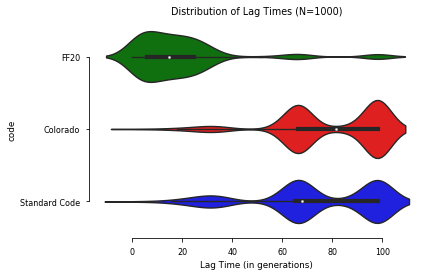

In [70]:
# plot violin plots for lag times
ax = sns.violinplot(
    x='lag', 
    y='code', 
    data=DF_3cd, 
    palette=colordict, 
    inner='box',
)
plt.title('Distribution of Lag Times (N=1000)')
plt.xlabel('Lag Time (in generations)')
sns.despine(trim=True)

#plt.savefig('bonkers.pdf')

Text(0.5,0,'Evolutionary Rates (in 1/generations)')

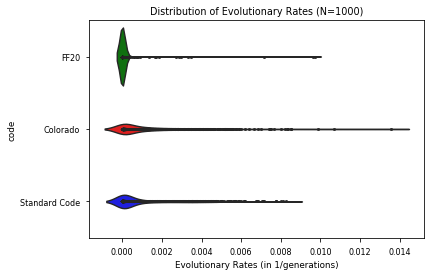

In [41]:
# plot violin plots for lag times
ax = sns.violinplot(x='rate', y='code', data=DF_3cd, palette=colordict, inner='point')
plt.title('Distribution of Evolutionary Rates (N=1000)')
plt.xlabel('Evolutionary Rates (in 1/generations)')
#plt.savefig('bonkers.pdf')

HBox(children=(IntProgress(value=0, description='Looping through codes: ', max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping through sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping through sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping through sims: ', max=1000), HTML(value='')))

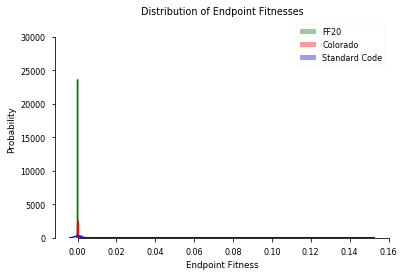

In [9]:
#############
# Figure 3e #
#############
# get endpoint fitness from simulations
sims = set(DF_3b['sim'])
codes = set(DF_3b['code'])
endpoints = {}
for code in tqdm(codes, desc='Looping through codes'):
    endpoints[code] = []
    df = DF_3b.loc[DF_3b['code'] == code]
    for sim in tqdm(sims, desc='Looping through sims'):
        endpoints[code].append(df.loc[df['sim'] == sim,'fitness'].iloc[-1])
        sns.despine(trim=True)
DF_endtimes = pd.DataFrame.from_dict(endpoints)

# plot distribution
for code in codes:
    sns.distplot(DF_endtimes[code], kde=True, hist=True, rug=False, norm_hist=True, color=colordict[code], label=code, rug_kws={"alpha" : 0.03})
# plt.xlim([0,0.6])
sns.despine(trim=True)
plt.xlabel('Endpoint Fitness')
plt.ylabel('Probability')
plt.legend()
plt.title('Distribution of Endpoint Fitnesses')
ax = plt.gca()
imgs = [obj for obj in ax.get_children() if isinstance(obj, mpl.image.AxesImage)]

#plt.savefig('Endtime Dist (Hist and KDE).svg')

NameError: name 'DF_3b' is not defined

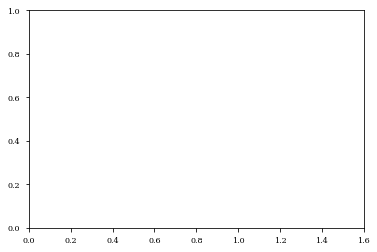

In [32]:
##############################################
# Sup Video: Distribution Evolving Over Time #
##############################################

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 1.6))

# define general parameters
sims = set(DF_3b['sim'])
codes = set(DF_3b['code'])


# define video parameters
fps = 3
bumper = 0#30
skip = 10
frames = int( (len(DF_3b.loc[(DF_3b['code'] == 'FF20') & (DF_3b['sim'] == 1)]['time']) - bumper) / skip -1 )
dpi = 100
# frames = 100
# # define frame generating function
# def framer(nFrame):
#     plt.cla()
#     # get current fitness from simulations
#     fitnesses = {}
#     for code in codes:
#         df = DF_3b.loc[DF_3b['code'] == code].set_index('sim')
#         fitnesses[code] = [df.loc[i, 'fitness'].iloc[(nFrame-bumper)] for i in sims]
#         t = df.loc[0, 'time'].iloc[nFrame-bumper]
#     DF_times = pd.DataFrame.from_dict(fitnesses)

#     # plot distribution
#     for code in codes:
#         ax = sns.distplot(DF_times[code], kde=False, hist=True, rug=False, norm_hist=True, color=colordict[code], label=code)
#     plt.xlim([0,1.6])
# #     plt.yticks(visible=False)
# #     ax.yaxis.grid(False)
#     sns.despine(trim=True)
#     plt.xlabel('Fitness')
#     plt.ylabel('Probability')
#     t_before_decimal = int(t)
#     t_after_decimal = t - t_before_decimal
#     t_string = str(t_before_decimal) + str(t_after_decimal)[1:3]
#     plt.title('Distribution of Fitnesses (t={0})'.format(t_string))
#     plt.legend()
    
def framer(nFrame):
    plt.cla()
    # adjust frame with offset
    framenum = int((nFrame + bumper)*skip)
    # get current fitness from simulations
    data = DF_3b.loc[framenum]

    # plot distribution
    for code in codes:
        ax = sns.distplot(data.loc[data['code'] == code]['fitness'], kde=True, hist=True, rug=False, norm_hist=True, color=colordict[code], label=code)
    plt.xlim([0,1.6])
#     ax.yaxis.grid(False)
    sns.despine(left=True)
    ax.axes.get_yaxis().set_visible(False)
    plt.xlabel('Fitness')
    plt.ylabel('Probability')
    t = data['time'].iloc[0]
    t_before_decimal = int(t)
    t_after_decimal = t - t_before_decimal
    t_string = str(t_before_decimal) + str(t_after_decimal)[1:3]
    plt.title('Distribution of Fitnesses (t={0})'.format(t_string))
    plt.legend()

# framer(5)
# anim = animation.FuncAnimation(fig, framer, frames=frames)
# anim.save('test.gif', writer='imagemagick', fps=fps, dpi=dpi);

## Figure 4: Fast fail codes can underpin intrinsic biocontainment

In [2]:
# get contour dataframes
DF = pd.DataFrame()
# # log filenames
# filenames = [
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_SC_contour_0/output/2018-04-12_SC_vs_SC_contour_0_concatenated.pickle', # vs SC
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_Colorado_contour_0/output/2018-04-11_SC_vs_Colorado_contour_0_concatenated.pickle', # vs colorado
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF20_contour_0/output/2018-04-11_SC_vs_FF20_contour_0_concatenated.pickle', # vs ff20
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED20_contour_0/output/2018-04-11_SC_vs_RED20_contour_0_concatenated.pickle', # vs red20
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF16_contour_1/output/2018-04-11_SC_vs_FF16_contour_1_concatenated.pickle', # vs ff16
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED14_contour_0/output/2018-04-11_SC_vs_RED14_contour_0_concatenated.pickle', # vs red14
# ]
# lin filenames
filenames = [
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_SC_lin_contour_1/output/2018-05-01_SC_vs_SC_lin_contour_1_concatenated.pickle', # vs SC lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_Colorado_lin_contour_0/output/2018-04-12_SC_vs_Colorado_lin_contour_0_concatenated.pickle', # vs colorado lin
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF20_lin_contour_1/output/2018-05-01_SC_vs_FF20_lin_contour_1_concatenated.pickle', # vs FF20 lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF16_lin_contour_1/output/2018-05-01_SC_vs_FF16_lin_contour_1_concatenated.pickle', # vs FF16 lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED20_lin_contour_1/output/2018-05-01_SC_vs_RED20_lin_contour_1_concatenated.pickle', # vs RED20 lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED15_lin_contour_0/output/2018-05-01_SC_vs_RED15_lin_contour_0_concatenated.pickle', # vs RED14
]
# get dataframes
dfs = []
for file in filenames:
    with open(file, 'rb') as handle:
        dfs.append(pickle.load(handle))
DF = pd.concat(dfs, copy=False)

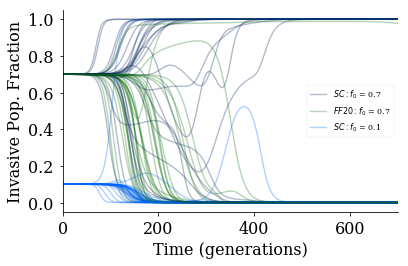

In [21]:
# 4a: show individual traces
def tracer(DF, code, linestyle='-', color=None, label=None):
    df = DF.loc[DF['code'] == code]
    sims = set(df['sim'])
    if color == None: color = colordict[code]
    for sim in sims:
        lildf = df.loc[df['sim'] == sim]
        t = lildf['time']
        x = lildf['popfrac'] / 1e6
        label = code if sim == 0 else ''
        plt.plot(t, x*1e6, linestyle, color=color, alpha=0.7, label=label)

# set figure options
labelsize=16
width = 6
height = width / 1.618
alpha = 0.3

# define blue shades
dark_blue = '#002255'
light_blue = '#0066ff'
green = '#107010'

# define low and high popfrac
lowfrac = 0.1
highfrac = 0.7

# define linestyles and colorshades
linestyle = {
    'Standard'+ str(lowfrac): ('-', light_blue),
    'Standard'+ str(highfrac): ('-', dark_blue),
    'FF20'+ str(highfrac): ('-', green),
}

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

# plot traces
# 4a: show individual traces
df = DF.loc[DF['N_0'].map(lambda n_0: n_0/1e6 in [lowfrac, highfrac])]
sims = list(set(df['sim']))
shuffle(sims)
label_small = True
label_large = True
label_ff20 = True
for sim in sims:
    if (sim % 10) == 0:
        for code in ['Standard', 'FF20']:
            lildf = df.loc[(df['sim'] == sim) & (df['code'] == code)]
            n_0 = lildf['N_0'][0]/1e6
            try:
                line, color = linestyle[code+str(n_0)]
            except:
                continue
            if n_0 == lowfrac:
                if label_small:
                    label = r'$SC: f_0$ = {0}'.format(lowfrac)
                    label_small = False
                else:
                    label = ''
            elif code == 'Standard':
                if label_large:
                    label = r'$SC: f_0$ = {0}'.format(highfrac)
                    label_large = False
                else:
                    label = ''
            else:
                if label_ff20:
                    label = r'$FF20: f_0$ = {0}'.format(highfrac)
                    label_ff20 = False
                else:
                    label = ''
            plt.plot(lildf['time'], lildf['popfrac'], line, label=label, color=color, alpha=alpha)

plt.ylim([-0.05,1.05])
plt.xlim([0,700])
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
# plt.title('Invasive Pop. Fraction vs Time in Head-to-Head Competition', fontsize=labelsize)
plt.xlabel('Time (generations)')
plt.ylabel('Invasive Pop. Fraction')
plt.legend()
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(width, height)
# ax.set_xscale("log")
sns.despine()
fig = plt.gcf()
fig.set_size_inches(width, height)
plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 4/4a_individual_traces.svg')
plt.show()

In [5]:
# generate probabilities
def contain_probability(DF, code):
    df = DF.loc[DF['code'] == code]
    N_0 = list(set(df['N_0']))
    N_0.sort()
    num_sims = len(df.loc[df['N_0'] == N_0[0]].loc[0])
    t = df.loc[df['sim'] == 0]['time']
    contain_probability = np.zeros((len(N_0), len(t)))
    for i, n_0 in enumerate(tqdm(N_0, desc='Processing Initial Conditions: ', leave=False)):
        lildf = df.loc[df['N_0'] == n_0]
        for j in tqdm(range(len(t)), desc='Processing sims: '):
            weedf = lildf.loc[j]
            contain_probability[i, j] = sum(weedf['popfrac'] == 0) / num_sims
            
    return contain_probability, t, N_0

In [23]:
# get traces for endpoint containment probabilities
def endpoint_contain(DF, code):
    df = DF.loc[DF['code'] == code]
    N_0 = list(set(df['N_0']))
    N_0.sort()
    num_sims = len(df.loc[df['N_0'] == N_0[0]].loc[0])
    timedf = df.loc[df['sim'] == 0]['time']
    endt = df.iloc[-1]
    endind = df.index[-1]
    df = df.loc[endind]
    contain = np.zeros(len(N_0))
    for i, n_0 in enumerate(N_0):
        lildf = df.loc[df['N_0'] == n_0]
        contain[i] = sum(lildf['popfrac'] == 0) / num_sims
    return contain, N_0

In [26]:
contain, N_0 = endpoint_contain(df, 'FF20')

In [27]:
contain

array([1.        , 0.94333333])

In [29]:
# unpickle for faster access
with open('/home/jonathan/Lab/Fast Fail/Figures/misc/contour_caching_lin.pickle', 'rb') as handle:
    FF20_contour, FF16_contour, RED20_contour, RED15_contour, Standard_contour, PROMISC20_contour, PROMISC15_contour, t, N_0 = pickle.load(handle)

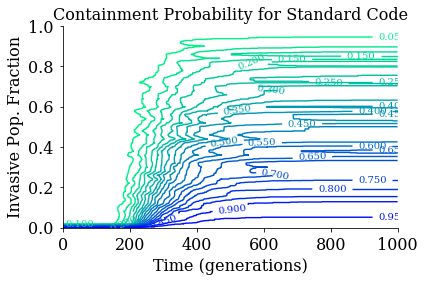

In [31]:
# generate log contour plot
contours = {
    'Standard':Standard_contour,
    'FF20':FF20_contour,
    'FF16':FF16_contour,
    'RED20':RED20_contour,
    'RED15':RED15_contour
}
cmaps = {
    'Standard':plt.cm.Blues,
    'Colorado':plt.cm.Reds,
    'FF20':plt.cm.Greens,
    'FF16':plt.cm.Oranges,
    'RED20':plt.cm.Purples,
    'RED15':plt.cm.copper_r
}

code = 'Standard'
contour = contours[code]
cmap = cmaps[code]

# set figure options
labelsize=16
width = 6
height = width / 1.618

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

X, Y = np.meshgrid(t, np.array(N_0)/1e6)
CS = plt.contour(X, Y, contour, 20, cmap=plt.cm.winter_r, vmin=0, vmax=1)
plt.clabel(CS, inline=1, fontsize=10)#, colors='black')
ax = plt.gca()
# ax.set_yscale("log")
# plt.xlim([0, 500])
# plt.ylim([3e3, 1e6])
# plt.yticks([1e0, 1e2, 1e4, 1e6])
plt.xticks([i*200 for i in range(6)])
# ax.set_xscale("log")

# cbar = plt.colorbar(CS, ticks=[0, 0.25, 0.5, 0.75, 1])
# cbar.ax.set_ylabel('Containment Probability')
plt.clim(0,1)

path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 4/'
# Add the contour line levels to the colorbar
plt.title('Containment Probability for {0} Code'.format(code), fontsize=labelsize)
plt.xlabel('Time (generations)')
plt.ylabel('Invasive Pop. Fraction')
sns.despine()
fig = plt.gcf()
fig.set_size_inches(width, height)
plt.savefig(path+'{0}_contour_lines.svg'.format(code))
plt.show()

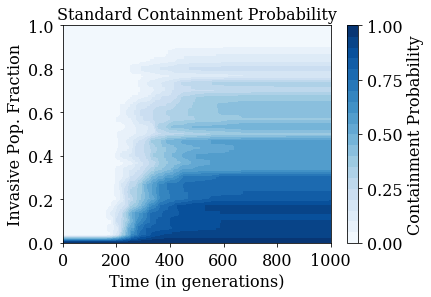

In [19]:
# 4b: generate linear contour plot
contours = {
    'Standard':Standard_contour,
    'Colorado':Colorado_contour,
    'FF20':FF20_contour,
    'FF16':FF16_contour,
    'RED20':RED20_contour,
    'RED14':RED14_contour,
    'PROMISC20':PROMISC20_contour,
    'PROMISC14':PROMISC14_contour
}
cmaps = {
    'Standard':plt.cm.Blues,
    'Colorado':plt.cm.Reds,
    'FF20':plt.cm.Greens,
    'FF16':plt.cm.Oranges,
    'RED20':plt.cm.Purples,
    'RED14':plt.cm.copper_r,
    'PROMISC20':plt.cm.Purples,
    'PROMISC14':plt.cm.copper_r
}

code = 'Standard'
contour = contours[code]
cmap = cmaps[code]

X, Y = np.meshgrid(t, np.array(N_0)/1e6)
CS = plt.contourf(X, Y, contour, 20, cmap=cmap, vmin=0, vmax=1)
#plt.clabel(CS, inline=1, fontsize=10)
ax = plt.gca()
# plt.ticklabel_format(style='sci', axis='y')
# plt.xlim([0, 500])
# plt.yticks([])
# plt.xticks([])
# ax.set_xscale("log")


cbar = plt.colorbar(CS, ticks=[0, 0.25, 0.5, 0.75, 1])
cbar.ax.set_ylabel('Containment Probability')
plt.clim(0,1)

path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 4/'
# Add the contour line levels to the colorbar
plt.title('{0} Containment Probability'.format(code), fontsize=labelsize)
plt.xlabel('Time (in generations)')
plt.ylabel('Invasive Pop. Fraction')
plt.savefig(path+'{0}_contour_lin.svg'.format(code))
plt.show()

In [35]:
# massage data for endpoint analysis

# lin filenames

filenames = [
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_SC_lin_contour_1/output/2018-05-01_SC_vs_SC_lin_contour_1_concatenated.pickle', # vs SC lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_Colorado_lin_contour_0/output/2018-04-12_SC_vs_Colorado_lin_contour_0_concatenated.pickle', # vs colorado lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF20_lin_contour_1/output/2018-05-01_SC_vs_FF20_lin_contour_1_concatenated.pickle', # vs FF20 lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF16_lin_contour_1/output/2018-05-01_SC_vs_FF16_lin_contour_1_concatenated.pickle', # vs FF16 lin
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED20_lin_contour_1/output/2018-05-01_SC_vs_RED20_lin_contour_1_concatenated.pickle', # vs RED20 lin
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED15_lin_contour_0/output/2018-05-01_SC_vs_RED15_lin_contour_0_concatenated.pickle', # vs RED15
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_PROMISC20_lin_contour_1/output/2018-05-01_SC_vs_PROMISC20_lin_contour_1_concatenated.pickle', # vs PROMISC20
]
# get dataframes
dfs = []
for file in tqdm(filenames, desc = 'grabbing dataframes'):
    with open(file, 'rb') as handle:
        df = pickle.load(handle).loc[1000]
        dfs.append(df)
DF = pd.concat(dfs, copy=False)
N_0 = list(set(DF.loc[DF['code'] == 'Standard']['N_0']))
N_0.sort()
num_reps = len(DF.loc[(DF['N_0']== N_0[0]) & (DF['code'] == 'Standard')])

for code in tqdm(colordict.keys() not in ['PROMISC20', 'PROMISC15', 'Colorado'], desc='colors'):
#     lilDF = DF.loc[DF['code'] == code]
    for n_0 in tqdm(N_0, desc='initial conditions'):
        DF.loc[(DF['code'] == code)&(DF['N_0'] == n_0), 'sim'] = np.arange(num_reps)
#         weeDF = lilDF.loc[lilDF['N_0'] == n_0]
#         weeDF['sim'] = np.arange(num_reps)

# convert to containment and popfrac
DF.loc[:,'popfrac'] = (DF.loc[:,'popfrac'] == 0)
DF.loc[:,'N_0'] /= 1e6

HBox(children=(IntProgress(value=0, description='grabbing dataframes: ', max=4), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='colors: ', max=1), HTML(value='')))

TypeError: 'bool' object is not iterable

In [12]:
N_0 = list(set(DF.loc[DF['code'] == 'Standard']['N_0']))
N_0.sort()
num_reps = len(DF.loc[(DF['N_0']== N_0[0]) & (DF['code'] == 'Standard')])

for code in tqdm(colordict.keys(), desc='colors'):
#     lilDF = DF.loc[DF['code'] == code]
    if code in ['PROMISC20', 'PROMISC15', 'Colorado']: continue
    if code == 'Standard Code':
        code = 'Standard'
    for n_0 in tqdm(N_0, desc='initial conditions'):
        DF.loc[(DF['code'] == code)&(DF['N_0'] == n_0), 'sim'] = np.arange(num_reps)
#         weeDF = lilDF.loc[lilDF['N_0'] == n_0]
#         weeDF['sim'] = np.arange(num_reps)

# convert to containment and popfrac
DF.loc[:,'popfrac'] = (DF.loc[:,'popfrac'] == 0)
DF.loc[:,'N_0'] /= 1e6

HBox(children=(IntProgress(value=0, description='colors: ', max=8), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=51), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=51), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=51), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=51), HTML(value='')))

HBox(children=(IntProgress(value=0, description='initial conditions: ', max=51), HTML(value='')))

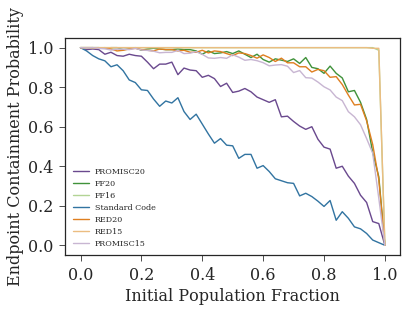

In [39]:
# 4c: generate endpoint probabilities for nonpromiscuous codes
contours = {
    'Standard':Standard_contour,
#     'Colorado':Colorado_contour,
    'FF20':FF20_contour,
    'FF16':FF16_contour,
    'RED20':RED20_contour,
    'RED15':RED15_contour,
    'PROMISC20':PROMISC20_contour,
    'PROMISC15':PROMISC15_contour
}
# df = DF.loc[DF['code'].map(lambda code: code not in ['PROMISC20', 'PROMISC15'])]
# adjust independent variable to be pop fraction
N_0.sort()
x = np.array(N_0)/1e6
for code, color in colordict.items():
#     if code in ['PROMISC20', 'PROMISC15', 'Colorado']: continue
    if code == 'Standard Code':
        codename = 'Standard'
    else:
        codename = code
    # handle markers
    if code in ['RED15', 'PROMISC15']:
        marker = '--'
    else:
        marker = '-'
    # get array at last timepoint
    y = contours[codename][:,-1]
    # plot
    plt.plot(np.array(x), y, marker, color, label=code)
plt.legend()
plt.xlabel('Initial Population Fraction')
plt.ylabel('Endpoint Containment Probability')
ax = plt.gca()
# ax.set_xscale("log")
# plt.savefig('test.svg')
plt.show()

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


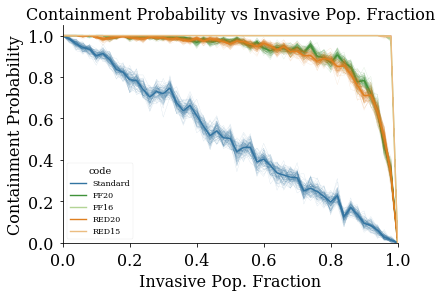

In [34]:
# 4c: generate endpoint probabilities for nonpromiscuous codes
# set figure options
labelsize=16
width = 6
height = width / 1.618

df = DF.loc[DF['code'].map(lambda code: code not in ['Colorado', 'PROMISC20', 'PROMISC15'])]
df_2 =  DF.loc[DF['code'].map(lambda code: code in ['PROMISC20', 'PROMISC15'])]
sns.tsplot(data=df, time='N_0', value='popfrac', unit='sim', condition='code', err_style='boot_traces', n_boot=100, color=colordict)
# sns.tsplot(data=df_2, time='N_0', value='popfrac', unit='sim', condition='code', 
#            err_style='boot_traces', n_boot=100, color=colordict, linestyle='--')


plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

ax = plt.gca()
# plt.xlim([0, 1])
plt.ylim([0, 1.05])
# plt.yticks([])
# plt.xticks([])

path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 4/'
plt.title('Containment Probability vs Invasive Pop. Fraction'.format(code), fontsize=labelsize)
plt.ylabel('Containment Probability')
plt.xlabel('Invasive Pop. Fraction')
sns.despine()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(width, height)
plt.savefig(path+'4c.svg')
plt.show()

In [27]:
set(df['code'])

{'FF16', 'FF20', 'RED15', 'RED20', 'Standard'}

## Figure 5: tRNA Promiscuity Does Not Impair Biocontainment

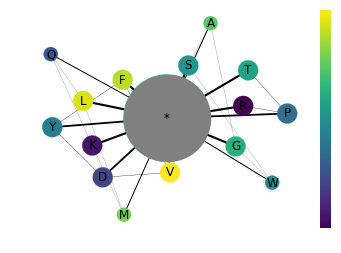

In [3]:
##############
# Figures 5a #
##############

# plot and save some shiznit
path = '/home/jon/Lab/Fast Fail/Figures/Figure 5/'
#fftable.plotGraph()#filename=path+'ff_graph.svg')
#ff16_table.codonTable.to_csv(path+'ff16.csv')
#f16_table.plotGraph(filename=path+'ff16_graph.svg')
# red20.plotGraph(filename=path+'reductionist_graph.svg')
# red20.codonTable.to_csv(path+'red20.csv')
# red15.plotGraph(filename=path+'reduct14_graph.svg')
# red15.codonTable.to_csv(path+'red15.csv')
# promisc20.plotGraph(filename=path+'promisc20_graph.svg')
# promisc20.codonTable.to_csv(path+'promisc20.csv')
promisc15.plotGraph(filename=path+'promisc15_graph.svg')
promisc15.codonTable.to_csv(path+'promisc15.csv')

In [3]:
##############
# Figures 5b #
##############

filenames = [
    '/home/jon/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_SC_lin_contour_1/output/2018-05-01_SC_vs_SC_lin_contour_1_concatenated.pickle', # vs SC lin
#     '/home/jon/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_Colorado_lin_contour_0/output/2018-04-12_SC_vs_Colorado_lin_contour_0_concatenated.pickle', # vs colorado lin
#     '/home/jon/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF20_lin_contour_1/output/2018-05-01_SC_vs_FF20_lin_contour_1_concatenated.pickle', # vs FF20 lin
#     '/home/jon/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF16_lin_contour_1/output/2018-05-01_SC_vs_FF16_lin_contour_1_concatenated.pickle', # vs FF16 lin
    '/home/jon/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED20_lin_contour_1/output/2018-05-01_SC_vs_RED20_lin_contour_1_concatenated.pickle', # vs RED20 lin
#     '/home/jon/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_RED15_lin_contour_0/output/2018-05-01_SC_vs_RED15_lin_contour_0_concatenated.pickle', # vs RED15
#     '/home/jon/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_PROMISC20_lin_contour_1/output/2018-05-01_SC_vs_PROMISC20_lin_contour_1_concatenated.pickle', # vs PROMISC20
#     '/home/jon/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_PROMISC15_lin_contour_2/output/2018-07-12_SC_vs_PROMISC15_lin_contour_2_concatenated.pickle', # vs PROMISC15

]
# get dataframes
dfs = []
for file in filenames:
    with open(file, 'rb') as handle:
        dfs.append(pickle.load(handle))
DF = pd.concat(dfs, copy=False)

In [ ]:
f = lambda code: code not in ['PROMISC20', 'PROMISC15']
ax1 = sns.tsplot(
    data=DF.loc[DF['code'].map(f)], 
    time='time', 
    value='fitness', 
    unit='sim', 
    condition='code', 
    color=colordict, 
    ci='sd',
    linestyle='-'
)
ax2 = sns.tsplot(
    data=DF.loc[(DF['code'].map(lambda code: not f(code)))], 
    time='time', 
    value='fitness', 
    unit='sim', 
    condition='code', 
    color=colordict, 
    ci='sd',
    linestyle='--'
)
# ax2 = sns.tsplot(data=df_col_3b, time='time', value='fitness', unit='sim', condition='code', color='red')
#ax3 = sns.tsplot(data=df_ff20_3b, time='time', value='fitness', unit='sim', condition='code', color='green')

plt.legend()
plt.title('Mean Fitness vs Time (1000 Simulations)')
plt.xlabel('Time (in generations)')
plt.ylabel('Fitness')
#plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 3/3b_fit_traces.pdf')
plt.show()

In [ ]:
# massage dataframes into proper format
N_0 = list(set(DF.loc[DF['code'] == 'Standard']['N_0']))
N_0.sort()
num_reps = len(DF.loc[(DF['N_0']== N_0[0]) & (DF['code'] == 'Standard')])
codes = ['Standard', 'RED20']
for code in codes:
    for n_0 in N_0:
        DF.loc[(DF['code'] == code)&(DF['N_0'] == n_0), 'sim'] = np.arange(num_reps)

DF.loc[:,'popfrac'] = (DF.loc[:,'popfrac'] == 0)
DF.loc[:,'N_0'] /= 1e6
# extract dataframe for figure 5
# logging.info("Plotting 5C")

df = DF.loc[DF['code'].map(lambda code: code not in ['Colorado', 'PROMISC20', 'RED20'])]
df_2 =  DF.loc[DF['code'].map(lambda code: code in ['PROMISC20', 'RED20'])]
# plot solid and dashed tsplots
sns.tsplot(data=df, time='N_0', value='popfrac', unit='sim', condition='code', err_style='boot_traces', n_boot=100, color=colordict)
sns.tsplot(data=df_2, time='N_0', value='popfrac', unit='sim', condition='code',
           err_style='boot_traces', n_boot=100, color=colordict, linestyle='--')

# format plot
# logging.info("Formatting 5B Main")
sns.despine()
plt.ylabel('Containment Probability')
plt.xlabel('Invasive Pop. Fraction')
fig = plt.gcf()
fig.set_size_inches(width, height)
plt.legend()
plt.show()

In [ ]:
# # 5c: generate endpoint probabilities for nonpromiscuous codes
# # get dataframes
# dfs = []
# for file in tqdm(filenames, desc = 'grabbing dataframes'):
#     with open(file, 'rb') as handle:
#         df = pickle.load(handle).loc[1000]
#         dfs.append(df)
# DF = pd.concat(dfs, copy=False)
# N_0 = list(set(DF.loc[DF['code'] == 'Standard']['N_0']))
# N_0.sort()
# num_reps = len(DF.loc[(DF['N_0']== N_0[0]) & (DF['code'] == 'Standard')])
# colordict = {
#     'Standard' : color_palette[1],
#     'RED20' : color_palette[7],
#     'RED15' : color_palette[6],
#     'PROMISC20' : color_palette[9],
#     'PROMISC15' : color_palette[8]
# }
# for code in tqdm(colordict.keys(), desc='colors'):
# #     lilDF = DF.loc[DF['code'] == code]
#     for n_0 in tqdm(N_0, desc='initial conditions'):
#         DF.loc[(DF['code'] == code)&(DF['N_0'] == n_0), 'sim'] = np.arange(num_reps)
# #         weeDF = lilDF.loc[lilDF['N_0'] == n_0]
# #         weeDF['sim'] = np.arange(num_reps)

# # convert to containment and popfrac
# DF.loc[:,'popfrac'] = (DF.loc[:,'popfrac'] == 0)
# DF.loc[:,'N_0'] /= 1e6

# set figure options
labelsize=16
width = 8/1.5
height = 6/1.5 #width / 1.618

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

df = DF.loc[DF['code'].map(lambda code: code not in ['Colorado', 'PROMISC20', 'RED20'])]
df_2 =  DF.loc[DF['code'].map(lambda code: code in ['PROMISC20', 'RED20'])]
sns.tsplot(data=df, time='N_0', value='popfrac', unit='sim', condition='code', err_style='boot_traces', n_boot=100, color=colordict)
sns.tsplot(data=df_2, time='N_0', value='popfrac', unit='sim', condition='code', 
           err_style='boot_traces', n_boot=100, color=colordict, linestyle='--')

ax = plt.gca()
# plt.xlim([0.7, 1])
# plt.ylim([])
# plt.yticks([0, 0.5, 1])
# plt.xticks([])

path = '/home/jon/Lab/Fast Fail/Figures/Figure 5/'
# plt.title('Containment Probability vs Invasive Pop. Fraction'.format(code), fontsize=labelsize)
sns.despine()
plt.ylabel('Containment Probability')
plt.xlabel('Invasive Pop. Fraction')
fig = plt.gcf()
fig.set_size_inches(width, height)
plt.savefig(path+'5c.svg')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

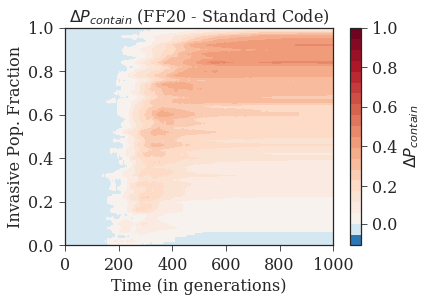

In [30]:
# Figure 5D

X, Y = np.meshgrid(t, np.array(N_0)/1e6)
CS = plt.contourf(X, Y, (RED20_contour - PROMISC20_contour), cmap=plt.cm.RdBu_r,
                 norm=MidpointNormalize(midpoint=0.), levels=np.linspace(-0.1, 1, 21) )
# plt.clabel(CS, inline=1, fontsize=10)
ax = plt.gca()
# plt.xlim([0, 500])
# plt.ylim([3e3, 1e6])
# ax.set_xscale("log")
# ax.set_yscale("log")

# set figure options
labelsize=16
width = 4
height = width / 1.618

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)
cbar = plt.colorbar(CS, ticks=np.linspace(-0.2, 1, 7, endpoint=True))
cbar.ax.set_ylabel('$\Delta P_{contain}$')


path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 5/'
# Add the contour line levels to the colorbar
plt.title(r'$\Delta P_{contain}$ (FF20 - Standard Code)', fontsize=labelsize)
plt.xlabel('Time (in generations)')
plt.ylabel('Invasive Pop. Fraction')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(width, height)
# plt.savefig(path+'delta_RED20.svg')
plt.show()

## Figure 6: Higher Dimensional Genetic Codes are dope

In [1]:
# Figure 6b
filenames = [
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_SC_lin_contour_1/output/2018-05-01_SC_vs_SC_lin_contour_1_concatenated.pickle', # vs SC lin
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF20_lin_contour_1/output/2018-05-01_SC_vs_FF20_lin_contour_1_concatenated.pickle', # vs FF20 lin
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FFQUAD_0/output/2018-05-03_FFQUAD_0_concatenated.pickle' # vs FFQUAD
]
dfs = []
for file in filenames:
    with open(file, 'rb') as handle:
        dfs.append(pickle.load(handle))
DF = pd.concat(dfs, copy=False)

ax1 = sns.tsplot(
    data=df, 
    time='time', 
    value='fitness', 
    unit='sim', 
    condition='code', 
    color=colordict, 
    ci='sd',
    linestyle='-'
)

NameError: name 'pickle' is not defined

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


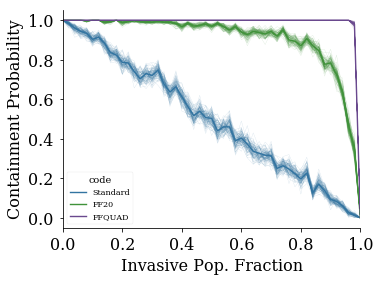

In [39]:
# # Figure 6c: Containment
# filenames = [
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_SC_lin_contour_1/output/2018-05-01_SC_vs_SC_lin_contour_1_concatenated.pickle', # vs SC lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FF20_lin_contour_1/output/2018-05-01_SC_vs_FF20_lin_contour_1_concatenated.pickle', # vs FF20 lin
#     '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/SC_vs_FFQUAD_lin_contour_1/output/2018-05-03_SC_vs_FFQUAD_lin_contour_1_concatenated.pickle', # vs FFQUAD
# ]

# dfs = []
# for file in tqdm(filenames, desc = 'grabbing dataframes'):
#     with open(file, 'rb') as handle:
#         df = pickle.load(handle).loc[1000]
#         dfs.append(df)
# DF = pd.concat(dfs, copy=False)
# N_0 = list(set(DF.loc[DF['code'] == 'Standard']['N_0']))
# N_0.sort()
# num_reps = len(DF.loc[(DF['N_0']== N_0[0]) & (DF['code'] == 'Standard')])

# colordict = {
#     'Standard' : color_palette[1],
#     'FF20' : color_palette[3],
#     'FFQUAD' : color_palette[9]
# }

# for code in tqdm(colordict.keys(), desc='colors'):
#     for n_0 in tqdm(N_0, desc='initial conditions'):
#         DF.loc[(DF['code'] == code)&(DF['N_0'] == n_0), 'sim'] = np.arange(num_reps)


# # convert to containment and popfrac
# DF.loc[:,'popfrac'] = (DF.loc[:,'popfrac'] == 0)
# DF.loc[:,'N_0'] /= 1e6

# set figure options
labelsize=16
width = 8/1.5
height = 6/1.5 #width / 1.618

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

sns.tsplot(data=DF, time='N_0', value='popfrac', unit='sim', condition='code', err_style='boot_traces', n_boot=100, color=colordict)

ax = plt.gca()
# plt.xlim([0.7, 1])
# plt.ylim([])
# plt.yticks([0, 0.5, 1])
# plt.xticks([])

path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 6/'
# plt.title('Containment Probability vs Invasive Pop. Fraction'.format(code), fontsize=labelsize)
sns.despine()
plt.ylabel('Containment Probability')
plt.xlabel('Invasive Pop. Fraction')
fig = plt.gcf()
fig.set_size_inches(width, height)
plt.savefig(path+'6c.svg')
plt.show()

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

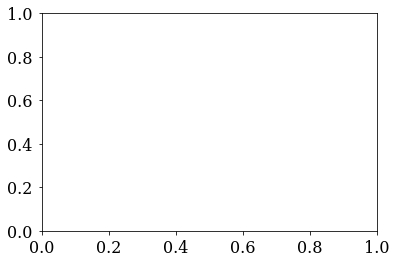

In [32]:
# set figure options
colordict = {
    'Standard' : color_palette[1],
    'FF20' : color_palette[3],
    'FFQUAD' : color_palette[9]
}

labelsize=16
width = 8/1.5
height = 6/1.5 #width / 1.618

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

sns.tsplot(data=DF, time='N_0', value='popfrac', unit='sim', condition='code', err_style='boot_traces', n_boot=100, color=colordict)

ax = plt.gca()
# plt.xlim([0.7, 1])
# plt.ylim([])
# plt.yticks([0, 0.5, 1])
# plt.xticks([])

path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 6/'
# plt.title('Containment Probability vs Invasive Pop. Fraction'.format(code), fontsize=labelsize)
sns.despine()
plt.ylabel('Containment Probability')
plt.xlabel('Invasive Pop. Fraction')
fig = plt.gcf()
fig.set_size_inches(width, height)
# plt.savefig(path+'6c.svg')
plt.show()

In [27]:
DF

,N_0,code,fitness,popfrac,sim,time
1000,0.0,Standard,NaN,True,0,1000.000000
1000,0.0,Standard,NaN,True,1,1000.000000
1000,0.0,Standard,NaN,True,2,1000.000000
1000,0.0,Standard,NaN,True,3,1000.000000
1000,0.0,Standard,NaN,True,4,1000.000000
1000,0.0,Standard,NaN,True,5,1000.000000
1000,0.0,Standard,NaN,True,6,1000.000000
1000,0.0,Standard,NaN,True,7,1000.000000
1000,0.0,Standard,NaN,True,8,1000.000000
1000,0.0,Standard,NaN,True,9,1000.000000
